# BTC ML/DL Trading strategy

In [1]:
# Enabling the notebook execution from this sub-folder
import sys, os, ipynbname
NOTEBOOK_NAME = f"{ipynbname.name()}.ipynb"
sys.path.append(os.path.abspath(os.path.join(os.path.dirname(NOTEBOOK_NAME), os.path.pardir)))

In [2]:
# Importin utils global variables and methods
from src.Utils import *

## Preliminary data import & handling

In [3]:
# Importing Bitcoin pre-processed financial data
df = pq.read_pandas(source=f"{Utils.ASSETS_FOLDER}/parquet/{Utils.get_asset_id('Bitcoin')}.parquet").to_pandas()

In [4]:
# Deepcopying the dataset
df_ = df.copy(deep=True)

**Reference**:
1. https://machinelearningmastery.com/xgboost-for-time-series-forecasting/

In [5]:
# Displaying first rows
df.head()

,Count,Open,High,Low,Close,Volume,VWAP
timestamp,,,,,,,
2018-01-01 00:01:00,229,13835.194,14013.8,13666.11,13850.176,31.550062,13827.062093
2018-01-01 00:02:00,235,13835.036,14052.3,13680.00,13828.102,31.046432,13840.362591
2018-01-01 00:03:00,528,13823.900,14000.4,13601.00,13801.314,55.061820,13806.068014
2018-01-01 00:04:00,435,13802.512,13999.0,13576.28,13768.040,38.780529,13783.598101
2018-01-01 00:05:00,742,13766.000,13955.9,13554.44,13724.914,108.501637,13735.586842


In [6]:
# Displaying column informations
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2136278 entries, 2018-01-01 00:01:00 to 2022-01-24 00:00:00
Data columns (total 7 columns):
 #   Column  Dtype  
---  ------  -----  
 0   Count   int32  
 1   Open    float64
 2   High    float64
 3   Low     float64
 4   Close   float64
 5   Volume  float64
 6   VWAP    float64
dtypes: float64(6), int32(1)
memory usage: 122.2 MB


In [7]:
# Resampling to 10-min bins
df = df.resample("10T").agg({
    "Count": "median",
    "Open": "first",
    "High": "max",
    "Low": "min",
    "Close": "last",
    "Volume": "mean",
    "VWAP": "mean"
})

# Removing NaN and broadcasting it to `Count`
df["Count"] = pd.to_numeric(arg=df["Count"], downcast="integer")
df.fillna(method="bfill", inplace=True)

# Deepcopying the dataset
df_sampled = df.copy(deep=True)

In [8]:
# Displaying first rows
df.head()

,Count,Open,High,Low,Close,Volume,VWAP
timestamp,,,,,,,
2018-01-01 00:00:00,437.0,13835.194,14052.3,13501.01,13720.260,60.545301,13756.177556
2018-01-01 00:10:00,301.0,13713.610,13948.6,13400.01,13626.110,49.918511,13665.050348
2018-01-01 00:20:00,308.0,13626.248,13826.8,13410.44,13648.280,53.002165,13623.876888
2018-01-01 00:30:00,228.5,13638.620,13800.0,13461.74,13636.600,36.841839,13652.429477
2018-01-01 00:40:00,245.0,13649.296,13800.0,13450.00,13693.004,48.451182,13640.833680


In [9]:
# Some statistical analysis
df.describe().style.background_gradient(cmap='summer')

,Count,Open,High,Low,Close,Volume,VWAP
count,213697.000000,213697.000000,213697.000000,213697.000000,213697.000000,213697.000000,213697.000000
mean,1036.575761,18706.849538,18780.568915,18636.490972,18706.957485,89.569931,18706.905651
std,1279.367076,17863.740822,17904.317644,17814.076700,17863.726108,114.678865,17863.725743
min,1.000000,3153.860000,3232.600000,3120.000000,3160.405000,0.001104,3159.199122
25%,318.000000,7124.448333,7159.000000,7098.480000,7124.657143,36.544792,7124.256692
50%,614.000000,9504.030000,9530.000000,9476.660000,9503.897143,57.727493,9503.429433
75%,1311.500000,32225.492857,32361.000000,32084.715549,32225.264388,98.577041,32221.782272
max,55717.500000,68716.598333,69024.200000,68447.000000,68724.006667,3985.862343,68619.267512


## Data aggregation

We are encouraged to add:
- additional metrics (RSI, moving averages, ...) and indicators from technical analysis
- additional data sources (from historical data API including FTX or Binance APIs)
- use of resampling routine to:
    - identify patterns
    - reduce the length of our data sample

### Log-returns & Day-time range

In [10]:
# Adding the daytime range for each line
try:
    df_t = [obs.hour for obs in list(df.index)]
    df["TimeRange"] = [Utils.get_daytime_range(time_) for time_ in df_t]
except KeyError:
    pass

In [11]:
# Computing log-returns
df["LogReturns"] = np.log(df["Close"]).diff()
df["LogReturns"].fillna(0, inplace=True)

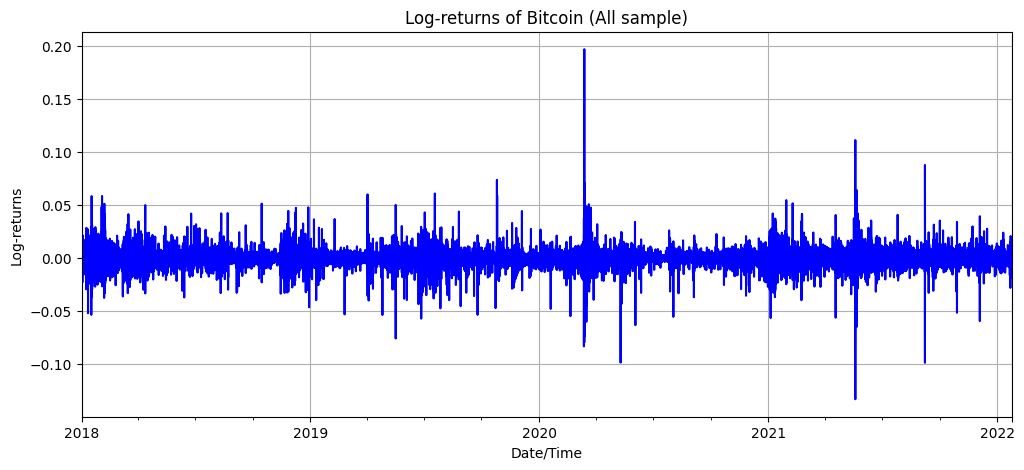

In [12]:
# Plotting log-returns
_ = df["LogReturns"].plot()
_ = plt.title("Log-returns of Bitcoin (All sample)")
_ = plt.xlabel("Date/Time")
_ = plt.ylabel("Log-returns")
_ = plt.grid()

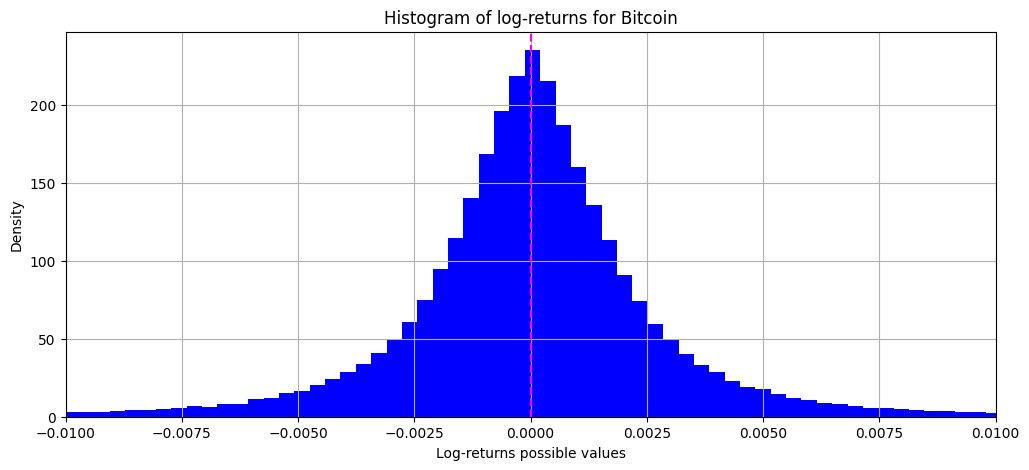

In [13]:
# Plotting log-returns
_ = df["LogReturns"].hist(bins=1000, density=True)
_ = plt.xlim([-0.01, 0.01])
_ = plt.title("Histogram of log-returns for Bitcoin")
_ = plt.xlabel("Log-returns possible values")
_ = plt.axvline(x = 0, color="magenta", ls="--")
_ = plt.ylabel("Density")

### Technical analysis indicators & Moving averages

In [14]:
def rsi(df, periods = 10, ema = True):
    """
    Returns a pd.Series with the Relative Strength Index (RSI)
    ==> Technical analysis indicator (see report)
    """
    # Computing the Close price delta
    close_delta = df["Close"].diff()

    # Make two series: one for lower closes and one for higher closes
    up = close_delta.clip(lower=0)
    down = -1 * close_delta.clip(upper=0)
    
    if ema == True:
        # Use exponential moving average
        ma_up = up.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()
        ma_down = down.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()
    else:
        # Use simple moving average
        ma_up = up.rolling(window = periods, adjust=False).mean()
        ma_down = down.rolling(window = periods, adjust=False).mean()
    
    # Computing the RSI
    rsi = ma_up / ma_down
    rsi = 100 - (100/(1 + rsi))
    return rsi

In [15]:
# Computing Rolled average close price
df["Rolled_Avg_Close"] = df["Close"].rolling(window=10).mean()

# Computing correlation
df["Corr"] = df["Close"].rolling(window=10).corr(df["Rolled_Avg_Close"])

# Computing Open-Close indicator
df["Open-Close"] = df["Open"] - df["Close"].shift(1)

# Computing Open-Open indicator
df["Open-Open"] = df["Open"] - df["Open"].shift(1)

# Computing the RSI () indicator
df["RSI"] = rsi(df)

# Computing the Bollinger Bands (BB) indicators
upper_2sd, mid_2sd, lower_2sd = ta.BBANDS(df["Close"], 
                                          nbdevup=2,
                                          nbdevdn=2,
                                          timeperiod=20)
df["BBANDS_U"] = upper_2sd
df["BBANDS_M"] = mid_2sd
df["BBANDS_L"] = lower_2sd

# Computing SMA moving averages for various time windows
df["SMA_SLOW"] = ta.SMA(df["Close"], timeperiod=5)
df["SMA_MEDIUM"] = ta.SMA(df["Close"], timeperiod=10)
df["SMA_FAST"] = ta.SMA(df["Close"], timeperiod=15)

# TODO: Adding other technical analysis indicator
# Momentum
# Standard deviation
# ...

In [16]:
# Getting DataFrame shape
df_shape_before = df.shape[0]

# Dropping newly-created NaN values
df.dropna(inplace=True)

# Getting DataFrame shape
df_shape_after = df.shape[0]

# Getting number of deletedrows
abs(df_shape_after - df_shape_before)

19

In [17]:
# Displaying DataFrame
df.head()

,Count,Open,High,Low,Close,Volume,VWAP,TimeRange,LogReturns,Rolled_Avg_Close,Corr,Open-Close,Open-Open,RSI,BBANDS_U,BBANDS_M,BBANDS_L,SMA_SLOW,SMA_MEDIUM,SMA_FAST
timestamp,,,,,,,,,,,,,,,,,,,,
2018-01-01 03:10:00,352.5,13417.998,13830.0,13346.75,13543.918,68.009210,13494.833017,5,0.009403,13403.3596,-0.380974,0.832,7.750,54.431361,13775.309957,13518.7868,13262.263643,13427.1296,13403.3596,13470.098800
2018-01-01 03:20:00,244.5,13545.052,13888.0,13428.03,13627.612,49.965753,13584.533490,5,0.006160,13423.3538,-0.556381,1.134,127.054,60.915374,13759.039247,13514.1544,13269.269553,13489.6124,13423.3538,13468.838667
2018-01-01 03:30:00,326.0,13633.470,13898.9,13400.00,13563.692,40.981728,13624.720631,5,-0.004702,13446.0278,-0.475076,5.858,88.418,54.352457,13751.685971,13511.0335,13270.381029,13513.1720,13446.0278,13469.692000
2018-01-01 03:40:00,168.0,13561.794,13798.5,13440.00,13549.480,25.024610,13570.538872,5,-0.001048,13459.2326,-0.490321,-1.898,-71.676,52.943308,13739.212147,13506.0935,13272.974853,13540.3736,13459.2326,13463.470800
2018-01-01 03:50:00,272.5,13546.378,13787.2,13360.00,13496.986,39.879553,13502.166655,5,-0.003882,13472.1920,-0.349084,-3.102,-15.416,47.851783,13724.411675,13499.1128,13273.813925,13556.3376,13472.1920,13455.853200


### External data sources (e.g. Binance, Coinbase, FTX, ...)

$\longrightarrow$ Potential extension (10-min data of **S&P 500**, **DJIA**)

## Data pre-processing

In [18]:
df.head()

,Count,Open,High,Low,Close,Volume,VWAP,TimeRange,LogReturns,Rolled_Avg_Close,Corr,Open-Close,Open-Open,RSI,BBANDS_U,BBANDS_M,BBANDS_L,SMA_SLOW,SMA_MEDIUM,SMA_FAST
timestamp,,,,,,,,,,,,,,,,,,,,
2018-01-01 03:10:00,352.5,13417.998,13830.0,13346.75,13543.918,68.009210,13494.833017,5,0.009403,13403.3596,-0.380974,0.832,7.750,54.431361,13775.309957,13518.7868,13262.263643,13427.1296,13403.3596,13470.098800
2018-01-01 03:20:00,244.5,13545.052,13888.0,13428.03,13627.612,49.965753,13584.533490,5,0.006160,13423.3538,-0.556381,1.134,127.054,60.915374,13759.039247,13514.1544,13269.269553,13489.6124,13423.3538,13468.838667
2018-01-01 03:30:00,326.0,13633.470,13898.9,13400.00,13563.692,40.981728,13624.720631,5,-0.004702,13446.0278,-0.475076,5.858,88.418,54.352457,13751.685971,13511.0335,13270.381029,13513.1720,13446.0278,13469.692000
2018-01-01 03:40:00,168.0,13561.794,13798.5,13440.00,13549.480,25.024610,13570.538872,5,-0.001048,13459.2326,-0.490321,-1.898,-71.676,52.943308,13739.212147,13506.0935,13272.974853,13540.3736,13459.2326,13463.470800
2018-01-01 03:50:00,272.5,13546.378,13787.2,13360.00,13496.986,39.879553,13502.166655,5,-0.003882,13472.1920,-0.349084,-3.102,-15.416,47.851783,13724.411675,13499.1128,13273.813925,13556.3376,13472.1920,13455.853200


In [19]:
# Computation of the target
df["Target"] = np.where(df["Close"].shift(-1) > df["Close"], 1, 0)

In [24]:
# X/Y split - Splitting the dataset into X/Y
# X = features, 
# Y = target
#X = df.copy() # X as a deep copy for security reason
#Y = X.pop("Target")

In [20]:
correlation_matrix = df.corr()
df.corr().style.background_gradient(cmap='autumn')

,Count,Open,High,Low,Close,Volume,VWAP,TimeRange,LogReturns,Rolled_Avg_Close,Corr,Open-Close,Open-Open,RSI,BBANDS_U,BBANDS_M,BBANDS_L,SMA_SLOW,SMA_MEDIUM,SMA_FAST,Target
Count,1.000000,0.549671,0.551852,0.546709,0.549534,0.617805,0.549552,-0.012570,-0.022761,0.550549,0.145740,0.013759,-0.061912,-0.037564,0.556749,0.551272,0.545611,0.550006,0.550549,0.550949,0.003871
Open,0.549671,1.000000,0.999984,0.999975,0.999986,-0.007649,0.999995,0.000379,-0.001676,0.999974,0.034513,0.009058,0.003038,0.006663,0.999865,0.999935,0.999873,0.999992,0.999974,0.999954,-0.007789
High,0.551852,0.999984,1.000000,0.999953,0.999985,-0.005768,0.999988,0.000348,0.000483,0.999964,0.034853,0.009318,0.002738,0.007321,0.999884,0.999928,0.999840,0.999981,0.999964,0.999946,-0.007840
Low,0.546709,0.999975,0.999953,1.000000,0.999978,-0.010272,0.999981,0.000364,0.000802,0.999943,0.034097,0.009058,0.003540,0.007967,0.999799,0.999898,0.999866,0.999967,0.999943,0.999920,-0.007905
Close,0.549534,0.999986,0.999985,0.999978,1.000000,-0.007813,0.999996,0.000362,0.002316,0.999964,0.034520,0.009250,0.002920,0.008121,0.999855,0.999924,0.999862,0.999984,0.999964,0.999944,-0.007942
Volume,0.617805,-0.007649,-0.005768,-0.010272,-0.007813,1.000000,-0.007775,-0.027803,-0.047458,-0.007074,0.198423,0.010253,-0.047859,-0.038625,-0.002274,-0.006668,-0.011149,-0.007425,-0.007074,-0.006843,0.009683
VWAP,0.549552,0.999995,0.999988,0.999981,0.999996,-0.007775,1.000000,0.000374,0.000422,0.999971,0.034512,0.009210,0.002963,0.007452,0.999862,0.999931,0.999870,0.999990,0.999971,0.999951,-0.007858
TimeRange,-0.012570,0.000379,0.000348,0.000364,0.000362,-0.027803,0.000374,1.000000,-0.003085,0.000422,-0.003937,0.000971,-0.002453,0.007781,0.000771,0.000432,0.000087,0.000392,0.000422,0.000439,0.000899
LogReturns,-0.022761,-0.001676,0.000483,0.000802,0.002316,-0.047458,0.000422,-0.003085,1.000000,-0.001115,-0.000845,0.103813,-0.012756,0.360791,-0.001179,-0.001246,-0.001313,-0.000799,-0.001115,-0.001211,-0.052241
Rolled_Avg_Close,0.550549,0.999974,0.999964,0.999943,0.999964,-0.007074,0.999971,0.000422,-0.001115,1.000000,0.034578,0.008881,-0.000988,0.003284,0.999911,0.999980,0.999917,0.999989,1.000000,0.999993,-0.007573


In [21]:
# Select upper triangle of correlation matrix (because it's a symmetric matrix)
upper = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(np.bool))
#print(upper)

# Find features with correlation greater than a fixed threshold
threshold = 0.9
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
print(to_drop)

['High', 'Low', 'Close', 'VWAP', 'Rolled_Avg_Close', 'BBANDS_U', 'BBANDS_M', 'BBANDS_L', 'SMA_SLOW', 'SMA_MEDIUM', 'SMA_FAST']


In [22]:
list(df.columns)

['Count',
 'Open',
 'High',
 'Low',
 'Close',
 'Volume',
 'VWAP',
 'TimeRange',
 'LogReturns',
 'Rolled_Avg_Close',
 'Corr',
 'Open-Close',
 'Open-Open',
 'RSI',
 'BBANDS_U',
 'BBANDS_M',
 'BBANDS_L',
 'SMA_SLOW',
 'SMA_MEDIUM',
 'SMA_FAST',
 'Target']

In [25]:
# Drop highly correlated features
to_drop = ["Open", "High", "Low", "VWAP", "SMA_SLOW"] # "Rolled_Avg_Close", "BBANDS_U", "BBANDS_M", "BBANDS_L", "SMA_MEDIUM", "SMA_FAST"
try:
    if len(to_drop) != 0:
        df.drop(to_drop, axis=1, inplace=True)
        print("Removing high-correlated columns")
except KeyError as e:
    print("High-correlated features already removed")

Removing high-correlated columns


In [422]:
# Outliers detection + removing (Winsorize methods)

In [84]:
# Confusion matrix + see report on + Intro ML Bologna

In [23]:
df.corr().style.background_gradient(cmap='autumn')

,Count,Open,High,Low,Close,Volume,VWAP,TimeRange,LogReturns,Rolled_Avg_Close,Corr,Open-Close,Open-Open,RSI,BBANDS_U,BBANDS_M,BBANDS_L,SMA_SLOW,SMA_MEDIUM,SMA_FAST,Target
Count,1.000000,0.549671,0.551852,0.546709,0.549534,0.617805,0.549552,-0.012570,-0.022761,0.550549,0.145740,0.013759,-0.061912,-0.037564,0.556749,0.551272,0.545611,0.550006,0.550549,0.550949,0.003871
Open,0.549671,1.000000,0.999984,0.999975,0.999986,-0.007649,0.999995,0.000379,-0.001676,0.999974,0.034513,0.009058,0.003038,0.006663,0.999865,0.999935,0.999873,0.999992,0.999974,0.999954,-0.007789
High,0.551852,0.999984,1.000000,0.999953,0.999985,-0.005768,0.999988,0.000348,0.000483,0.999964,0.034853,0.009318,0.002738,0.007321,0.999884,0.999928,0.999840,0.999981,0.999964,0.999946,-0.007840
Low,0.546709,0.999975,0.999953,1.000000,0.999978,-0.010272,0.999981,0.000364,0.000802,0.999943,0.034097,0.009058,0.003540,0.007967,0.999799,0.999898,0.999866,0.999967,0.999943,0.999920,-0.007905
Close,0.549534,0.999986,0.999985,0.999978,1.000000,-0.007813,0.999996,0.000362,0.002316,0.999964,0.034520,0.009250,0.002920,0.008121,0.999855,0.999924,0.999862,0.999984,0.999964,0.999944,-0.007942
Volume,0.617805,-0.007649,-0.005768,-0.010272,-0.007813,1.000000,-0.007775,-0.027803,-0.047458,-0.007074,0.198423,0.010253,-0.047859,-0.038625,-0.002274,-0.006668,-0.011149,-0.007425,-0.007074,-0.006843,0.009683
VWAP,0.549552,0.999995,0.999988,0.999981,0.999996,-0.007775,1.000000,0.000374,0.000422,0.999971,0.034512,0.009210,0.002963,0.007452,0.999862,0.999931,0.999870,0.999990,0.999971,0.999951,-0.007858
TimeRange,-0.012570,0.000379,0.000348,0.000364,0.000362,-0.027803,0.000374,1.000000,-0.003085,0.000422,-0.003937,0.000971,-0.002453,0.007781,0.000771,0.000432,0.000087,0.000392,0.000422,0.000439,0.000899
LogReturns,-0.022761,-0.001676,0.000483,0.000802,0.002316,-0.047458,0.000422,-0.003085,1.000000,-0.001115,-0.000845,0.103813,-0.012756,0.360791,-0.001179,-0.001246,-0.001313,-0.000799,-0.001115,-0.001211,-0.052241
Rolled_Avg_Close,0.550549,0.999974,0.999964,0.999943,0.999964,-0.007074,0.999971,0.000422,-0.001115,1.000000,0.034578,0.008881,-0.000988,0.003284,0.999911,0.999980,0.999917,0.999989,1.000000,0.999993,-0.007573


In [129]:
# GridSearch on model with the 5-10 best features

In [24]:
LAGGED_SERIES = list(range(1, 20))
for lag in LAGGED_SERIES:
    df[f"Close (t - {lag})"] = df["Close"].shift(periods=lag)
    df[f"Target (t - {lag})"] = df["Target"].shift(periods=lag)
    df[f"RSI (t - {lag})"] = df["RSI"].shift(periods=lag)
# Dropping newly-created NaN values
df.dropna(inplace=True)

In [25]:
# Getting initial dataset (subset of time range)
btc_2018 = df["2018-01": "2018-04"]

In [26]:
btc_2018

,Count,Open,High,Low,Close,Volume,VWAP,TimeRange,LogReturns,Rolled_Avg_Close,...,RSI (t - 16),Close (t - 17),Target (t - 17),RSI (t - 17),Close (t - 18),Target (t - 18),RSI (t - 18),Close (t - 19),Target (t - 19),RSI (t - 19)
timestamp,,,,,,,,,,,,,,,,,,,,,
2018-01-01 06:20:00,340.5,13583.240000,14000.0,13473.08,13715.620000,54.654752,13681.354901,0,0.009870,13599.855400,...,52.943308,13563.692000,0.0,54.352457,13627.612000,0.0,60.915374,13543.918000,1.0,54.431361
2018-01-01 06:30:00,209.5,13719.510000,14000.0,13602.53,13718.398000,24.363162,13709.096355,0,0.000203,13606.389000,...,47.851783,13549.480000,0.0,52.943308,13563.692000,0.0,54.352457,13627.612000,0.0,60.915374
2018-01-01 06:40:00,260.0,13718.238000,14442.9,13644.99,13801.032000,49.739558,13780.980585,0,0.006006,13626.582200,...,44.706537,13496.986000,0.0,47.851783,13549.480000,0.0,52.943308,13563.692000,0.0,54.352457
2018-01-01 06:50:00,278.5,13801.034000,14141.0,13713.26,13868.724000,54.396066,13859.155262,0,0.004893,13649.835600,...,40.820024,13462.424000,0.0,44.706537,13496.986000,0.0,47.851783,13549.480000,0.0,52.943308
2018-01-01 07:00:00,296.0,13865.944000,14224.0,13738.98,13917.490000,26.822479,13888.212163,0,0.003510,13681.119400,...,52.851384,13417.366000,1.0,40.820024,13462.424000,0.0,44.706537,13496.986000,0.0,47.851783
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-04-30 23:10:00,360.0,9212.412000,9250.0,9181.33,9213.765000,60.863333,9215.946174,4,0.000454,9225.639506,...,46.858398,9307.681667,0.0,47.545054,9327.812000,0.0,59.703524,9324.134000,1.0,57.934631
2018-04-30 23:20:00,280.0,9213.950000,9237.7,9189.71,9223.484000,64.800272,9215.091222,4,0.001054,9225.518506,...,44.616087,9306.378000,0.0,46.858398,9307.681667,0.0,47.545054,9327.812000,0.0,59.703524
2018-04-30 23:30:00,222.5,9223.408333,9240.9,9206.97,9229.543333,29.943373,9226.764245,4,0.000657,9226.572006,...,31.054054,9302.295000,0.0,44.616087,9306.378000,0.0,46.858398,9307.681667,0.0,47.545054


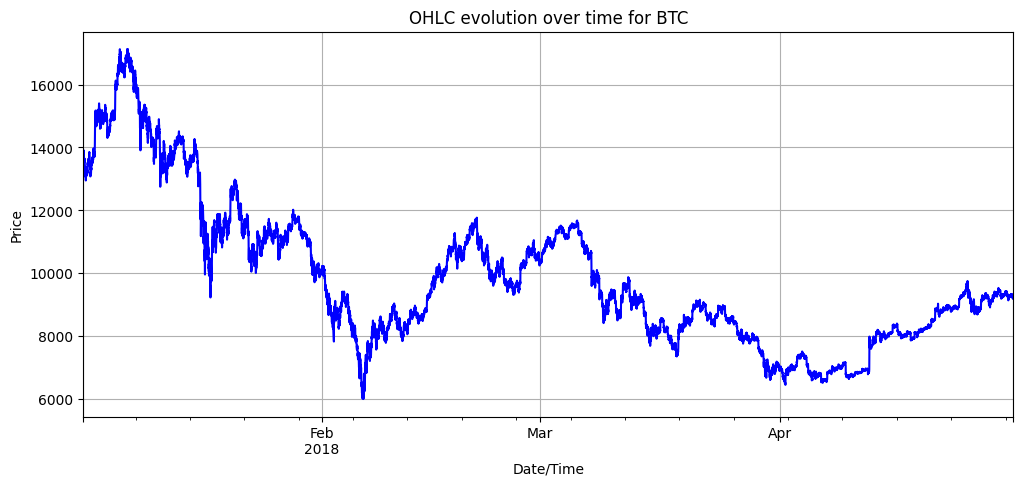

In [27]:
# Plotting OHLC time series
_ = btc_2018["Close"].plot()
_ = plt.grid()
_ = plt.xlabel("Date/Time")
_ = plt.ylabel("Price")
_ = plt.title("OHLC evolution over time for BTC")

In [28]:
# Getting DataFrame shape
nb_obs, nb_cols = btc_2018.shape
print(f"Number of 10-min bins:\t {nb_obs}\nNumber of columns:\t {nb_cols}")

Number of 10-min bins:	 17242
Number of columns:	 78


In [29]:
from sklearn.metrics import confusion_matrix, classification_report
from xgboost import *
import time
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [31]:
# Removing old model files
files = glob.glob("../out/models/model_*")
for f in files:
    os.remove(f)
print("Removing model files from previous fitting steps")

Removing model files from previous fitting steps


In [83]:
# Test on WF

# Splitting X/Y
X = btc_2018.copy() # X as a deep copy for security reason
Y = X.pop("Target")

# Defining the number of train points and number of records
n_train = 2_000
n_records = 2_200 #len(btc_2018)//2

# Declaring the main model # 0.1 for eta
model = XGBClassifier(learning_rate=0.03, n_estimators=200, max_depth=4, max_leaves=3, objective='binary:logistic') #, booster='gbtree')

# Model name (on-disk storage)
MODEL_NAME = f"../out/models/model_{0}"

# Horizon lags
HORIZON_LAGS = {
    "future": 10, # 15
    "past": 1500 # None
}

# Metrics
METRICS = {
    "train_size": {}, # Shape of the train set
    "test_size": {}, # Shape of the test set
    "exec_time": {}, # Execution (fitting + prediction) time
    "model_size": {} # File size of the on-disk model
}

# Predictions dataframes
preds_cols = ["ts"] + [str(i) for i in range(1, HORIZON_LAGS["future"] + 1)] + ["conf_mat"] + ["report"]
preds = pd.DataFrame(columns=preds_cols)

# Looping over each time t
for k, i in enumerate((pbar := tqdm.tqdm_notebook(range(n_train, n_records), colour="red"))):
    #print(k, "--", i)
    
    # Train/test split for X
    X_train = X.iloc[0: i] # X.iloc[i - HORIZON_LAGS["past"]: i] # X.iloc[0: i]
    X_test = X.iloc[i: i + HORIZON_LAGS["future"]]
    
    # Getting the current datetime
    dt_now = list(X_train.index)[-1]
    
    # Defining the scaler pre-processor
    scaler = MinMaxScaler() # StandardScaler()
    
    # Scaling X_train
    X_train_scaled = scaler.fit_transform(X_train)
    # - None: XGBoost model fitting with X_train_scaled & Y_train
    # - X_test_scaled: Scaling of X_test using this scaler with input as X_test
    # - Y_pred: XGBoost model prediction with input X_test_scaled
    
    # Saving lengths
    METRICS["train_size"][dt_now] = len(X_train)
    METRICS["test_size"][dt_now] = len(X_test)

    # Train/test split for Y
    Y_train = Y.iloc[0: i] # Y.iloc[i - HORIZON_LAGS["past"]: i] # Y.iloc[0: i]
    Y_test = Y.iloc[i: i + HORIZON_LAGS["future"]]
    
    # Timing the fitting & prediction operations
    start_time = time.time()
    
    # If first iteration, only fit
    if k == 0:
        model.fit(X=X_train, y=Y_train) # or X_train_scaled
    else:        
        # If next iterations, fitting using previous knowledge (saved on-disk)
        model.fit(X=X_train, y=Y_train, xgb_model=MODEL_NAME) # or X_train_scaled
    
    # Model name (on-disk storage) ==> Use the k-th counter to track iterations on MODEL_NAME to re-use fit
    MODEL_NAME = f"../out/models/model_{k}"
    
    # Saving the model for incremental learning (growing filtration)
    model.get_booster().save_model(MODEL_NAME)
    
    # Scaling the X_test dataset with the scaler trained on X_train
    X_test_scaled = scaler.transform(X_test)
    
    # Predicting the HORIZON_LAGS["future"] market movements from dt_now
    Y_pred = model.predict(X=X_test) # or X_test_scaled
    #print(Y_pred)
    
    if k == 0:
        METRICS["model_size"][dt_now] = 0.0
    else:
        METRICS["model_size"][dt_now] = os.path.getsize(MODEL_NAME)/1e6
    
    # Storing the duration time for fitting step
    dur_time = time.time() - start_time
    METRICS["exec_time"][dt_now] = dur_time
    #print(f"Exec. time: {dur_time:.3f}s")
    pbar.set_description(f"#{k} - Current time: {dt_now}\t\t | Exec. time: {dur_time:.3f}s | FITTING")

    # Computing the confusion matrix
    conf_mat = confusion_matrix(y_true=list(Y_test.values), y_pred=list(Y_pred))
    
    # Getting classification report
    clf_report = classification_report(y_true=Y_test, y_pred=Y_pred, output_dict=True)
    
    # Appending the predictions
    preds = preds.append(pd.DataFrame([[dt_now] + list(Y_pred) + [conf_mat] + [clf_report]], columns=preds_cols), ignore_index=True)
    
    #print(train.shape, test.shape)

  0%|          | 0/200 [00:00<?, ?it/s]

**References**:
1. https://greyhoundanalytics.com/blog/backtestingpy-a-complete-quickstart-guide/
2. https://kernc.github.io/backtesting.py/doc/backtesting/backtesting.html#backtesting.backtesting.Backtest.plot
3. https://machinelearningmastery.com/backtest-machine-learning-models-time-series-forecasting/

In [84]:
# Broadcasting into a Pandas DataFrame
METRICS_ = pd.DataFrame(METRICS)

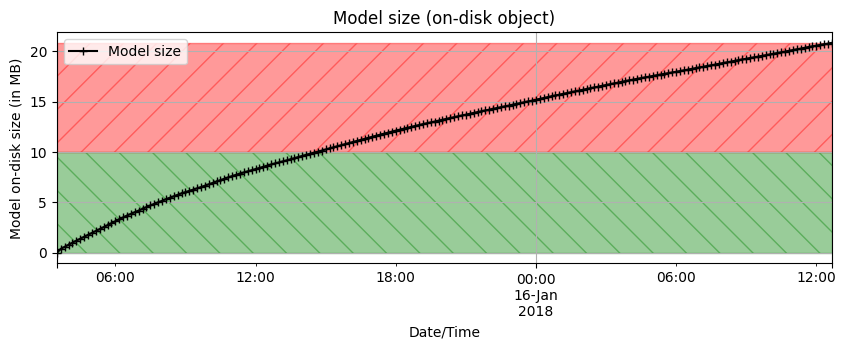

In [86]:
# Plotting model file size
_ = METRICS_["model_size"].plot(marker="+", label="Model size", figsize=(10, 3), color="black")
threshold_ = 10
_ = plt.axhspan(ymin=METRICS_["model_size"].min(), ymax=threshold_, color="green", hatch="\\", alpha=0.4)
_ = plt.axhspan(ymin=threshold_, ymax=METRICS_["model_size"].max(), color="red", hatch="/", alpha=0.4)
_ = plt.grid()
_ = plt.xlabel("Date/Time")
_ = plt.ylabel("Model on-disk size (in MB)")
_ = plt.title("Model size (on-disk object)")
_ = plt.legend()

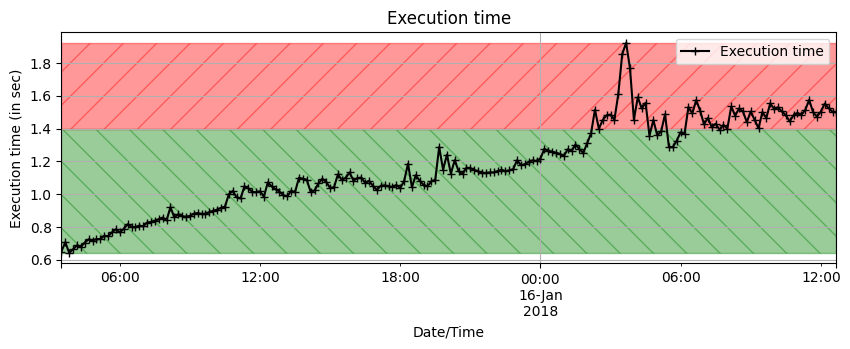

In [87]:
# Plotting exec. time for each fitting step
_ = METRICS_["exec_time"].plot(marker="+", label="Execution time", figsize=(10, 3), color="black")
threshold_ = 1.4
_ = plt.axhspan(ymin=METRICS_["exec_time"].min(), ymax=threshold_, color="green", hatch="\\", alpha=0.4)
_ = plt.axhspan(ymin=threshold_, ymax=METRICS_["exec_time"].max(), color="red", hatch="/", alpha=0.4)
_ = plt.grid()
_ = plt.xlabel("Date/Time")
_ = plt.ylabel("Execution time (in sec)")
_ = plt.title("Execution time")
_ = plt.legend()

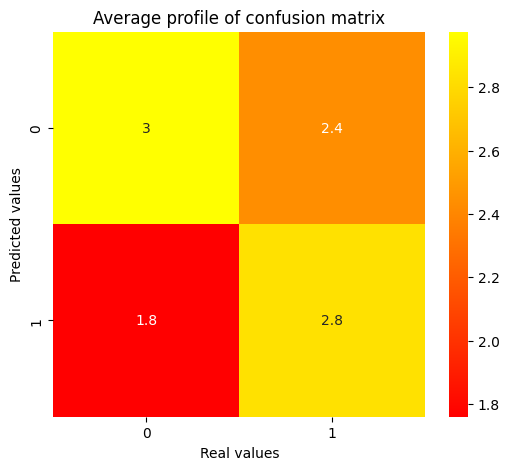

In [88]:
# Getting the 
_ = plt.figure(figsize=(6, 5))
_ = sns.heatmap(preds["conf_mat"].mean(), annot=True, cmap="autumn")
_ = plt.title("Average profile of confusion matrix")
_ = plt.xlabel("Real values")
_ = plt.ylabel("Predicted values")

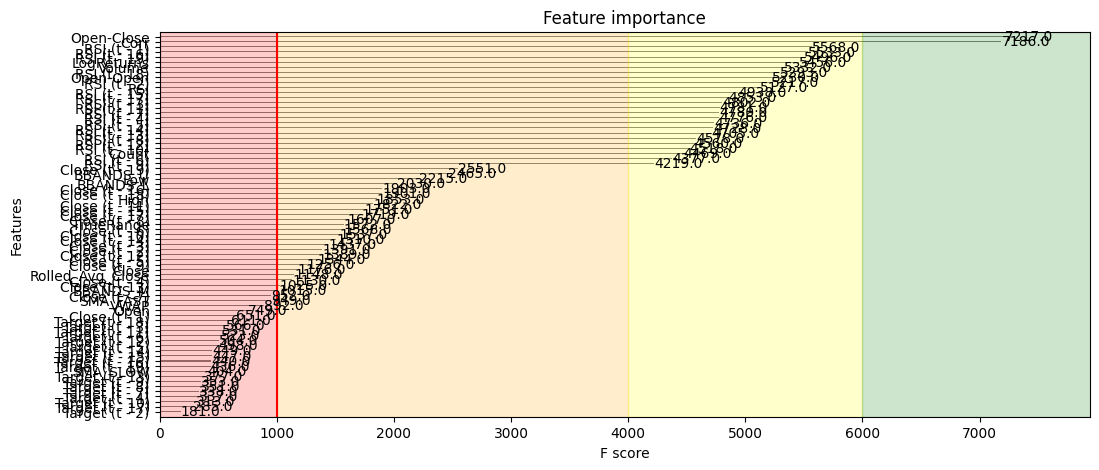

In [108]:
# Plot features 
_ = plot_importance(booster=model.get_booster(), grid=False, color="gray")
_ = plt.axvline(x = 1000, color="red")

# Adding region to "categorize" features importance
_ = plt.axvspan(xmin=0, xmax=1000, color="red", alpha=0.2)
_ = plt.axvspan(xmin=1000, xmax=4000, color="orange", alpha=0.2)
_ = plt.axvspan(xmin=4000, xmax=6000, color="yellow", alpha=0.2)
_ = plt.axvspan(xmin=6000, xmax=8000, color="green", alpha=0.2)

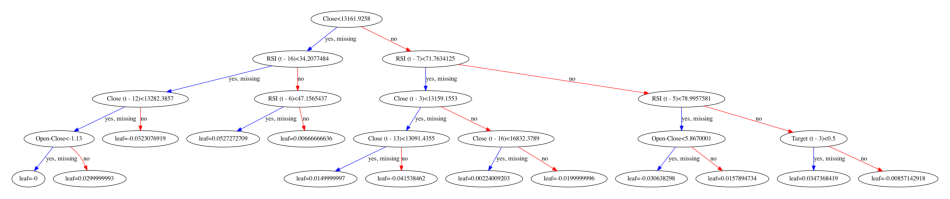

In [109]:
_ = plot_tree(booster=model.get_booster())

In [79]:
a = 1
for k, i in enumerate((pbar := tqdm.tqdm_notebook(range(n_train, n_records), colour="red"))):
    pbar.set_description(f"#{k} - Current time: {i}\t\t | FITTING")
    time.sleep(0.01)

  0%|          | 0/200 [00:00<?, ?it/s]

## Strategy

In [110]:
# Defining the trading strategy
import xgboost
import pandas_ta as tap
from backtesting import Backtest
from backtesting import Strategy
from backtesting.lib import crossover
from backtesting.test import EURUSD
from backtesting.lib import resample_apply

Loading BokehJS ...

In [76]:
# Dataset
#btc_2018 = df["2018-01": "2018-04"]

In [252]:
try:
    preds.set_index("ts", inplace=True)
except KeyError:
    pass
preds.head()

,1,2,3,4,5,6,7,8,9,10,conf_mat,report
ts,,,,,,,,,,,,
2018-01-15 03:30:00,0,1,1,1,0,0,0,1,0,0,"[[4, 2], [2, 2]]","{'0': {'precision': 0.6666666666666666, 'recal..."
2018-01-15 03:40:00,1,1,1,0,0,0,1,0,0,1,"[[3, 2], [2, 3]]","{'0': {'precision': 0.6, 'recall': 0.6, 'f1-sc..."
2018-01-15 03:50:00,1,1,0,0,0,1,0,0,1,1,"[[3, 2], [2, 3]]","{'0': {'precision': 0.6, 'recall': 0.6, 'f1-sc..."
2018-01-15 04:00:00,1,0,0,0,1,0,0,1,1,1,"[[3, 1], [2, 4]]","{'0': {'precision': 0.6, 'recall': 0.75, 'f1-s..."
2018-01-15 04:10:00,0,0,0,1,0,0,1,1,1,0,"[[3, 0], [3, 4]]","{'0': {'precision': 0.5, 'recall': 1.0, 'f1-sc..."


In [306]:
ONLY_PREDS_COLUMNS = [str(k) for k in list(range(1, 11))]

In [265]:
def get_preds_time_interval(preds_: pd.DataFrame) -> dict:
    """
    Function returning start and end datetimes from predictions
    """
    i = list(preds.index)
    return {"start_dt": i[0], "end_dt": i[-1]}

In [266]:
s, e = get_preds_time_interval(preds).values()
s, e

(Timestamp('2018-01-15 03:30:00'), Timestamp('2018-01-16 12:40:00'))

In [270]:
data = btc_2018.loc[s:e]
data.head()

,Count,Open,High,Low,Close,Volume,VWAP,TimeRange,LogReturns,Rolled_Avg_Close,...,RSI (t - 16),Close (t - 17),Target (t - 17),RSI (t - 17),Close (t - 18),Target (t - 18),RSI (t - 18),Close (t - 19),Target (t - 19),RSI (t - 19)
timestamp,,,,,,,,,,,,,,,,,,,,,
2018-01-15 03:30:00,253.0,13447.604000,13540.13,13260.00,13444.432000,31.657208,13424.133760,5,4.462815e-07,13458.997886,...,71.844204,13699.381667,1.0,68.828100,13687.476667,1.0,67.795321,13620.710000,1.0,61.328190
2018-01-15 03:40:00,244.5,13445.022000,13652.90,13313.60,13509.638000,26.185348,13481.467479,5,4.838314e-03,13453.098353,...,73.403559,13735.171667,1.0,71.844204,13699.381667,1.0,68.828100,13687.476667,1.0,67.795321
2018-01-15 03:50:00,284.0,13505.280000,13743.70,13342.00,13499.326667,42.701547,13524.691853,5,-7.635490e-04,13454.286392,...,55.468957,13754.690000,0.0,73.403559,13735.171667,1.0,71.844204,13699.381667,1.0,68.828100
2018-01-15 04:00:00,330.0,13499.108333,13689.70,13292.45,13560.878000,39.510889,13521.744346,5,4.549222e-03,13466.606025,...,55.789045,13652.136667,1.0,55.468957,13754.690000,0.0,73.403559,13735.171667,1.0,71.844204
2018-01-15 04:10:00,321.5,13555.356000,13744.40,13393.00,13560.261667,60.063695,13553.071101,5,-4.545040e-05,13479.227359,...,61.724447,13654.871667,1.0,55.789045,13652.136667,1.0,55.468957,13754.690000,0.0,73.403559


In [164]:
# Defining the strategy
class RsiOscillator(Strategy):
    """
    Class Strategy
    """
    upper_bound = 70
    lower_bound = 30
    rsi_window = 3

    # Do as much initial computation as possible
    def init(self):
        """
        """
        self.daily_rsi = self.I(tap.rsi, pd.Series(self.data.Close), self.rsi_window)
    
    # Step through bars one by one
    # Note that multiple buys are a thing here
    def next(self):
        #print(len(self.data.df))
        price = self.data.df.iloc[-1]
        #print(type(price))
        
        print(len(self.daily_rsi))
        # Use the history (thanks to the I (indicator function)) + 
        # Use the prediction for the l (future lag) next 10 iterations from now on 
        # To do so, we are taking the current_dt and adding the delta (l: future lag to get a dataframe/series
        # with our different predicted models (binary target and/or another ))
        # For instance, check whether we have an increasing/decreasing trend for the next values
        
        current_dt = price.name
        #print(current_dt, price["Close"])
        #print("---")
        self.hello_world()
        if crossover(self.daily_rsi, self.upper_bound):
            self.position.close()
        # Check crossover
        elif crossover(self.lower_bound, self.daily_rsi):
            self.buy()

In [165]:
def MovingAverage(closes:pd.Series, n:int) -> pd.Series:
    return pd.Series(closes).rolling(n).mean()

In [399]:
class SmaCross(Strategy):
    sma_fast = 12
    sma_slow = 24
    
    def init(self):
        self.sma1 = self.I(MovingAverage, self.data.Close, self.sma_fast)
        self.sma2 = self.I(MovingAverage, self.data.Close, self.sma_slow)

    def next(self):
        if self.position and crossover(self.sma1, self.sma2):
            self.buy()
        elif self.position and crossover(self.sma2, self.sma1):
            self.position.close()

In [440]:
class Custom(Strategy):
    def init(self):
        """
        Initialize the strategy
        """
        # To pass additional data, write it here or overload the Backtest class to pass 
        # via the _strategy member, any additional information
        
        self.sma1 = self.I(MovingAverage, self.data.Close, 12)
        self.sma2 = self.I(MovingAverage, self.data.Close, 24)
        self.daily_rsi = self.I(tap.rsi, pd.Series(self.data.Close), 3)

        pass

    def next(self):
        """
        Main strategy runtime method
        Main method where strategy decisions upon data precomputed in Strategy.init() take place.
        """
        
        # Getting last bar (OHLCV) + Indicators
        current_bar = self.data.df.iloc[-1]
        
        # Getting current datetime
        current_dt = current_bar.name
        #print(f"Processing --> {current_dt}")
        
        # Getting predictions for the next 10 times
        current_preds = self.preds.loc[current_dt][ONLY_PREDS_COLUMNS]
        
        # Computing potential future trends for short and long terms
        short_term = current_preds[:5].sum() # For the 5 first next times
        long_term = current_preds[5:].sum() # For the 5 last next times
        
        # Computing number of UP/DOWN predictions on whole time horizon
        whole_term_up = np.array(short_term + long_term) # For the 10 next times (aggregation ==> sum)
        whole_term_down = len(ONLY_PREDS_COLUMNS) - np.array(whole_term_up)
        #print(f"U{whole_term_up}/D{whole_term_down}")
        
        # Implementation of the trading strategy
        # TODO
        if whole_term_up > 3:
            print("BUY")
            self.buy()
        elif whole_term_down > 3:
            print("SELL")
            self.position.close()
        
        """
        # SMA crossover
        if crossover(self.sma1, self.sma2):
            print("C1")
        elif crossover(self.sma2, self.sma1):
            print("C2")
        """

In [441]:
class BT(Backtest):
    def __init__(self, predictions_: pd.DataFrame, *args, **kwargs):
        """
        """
        print("Initializing the backtest instance ...")
        super().__init__(*args, **kwargs)
        self._strategy.hello_world = lambda x: x == 1
        self._strategy.preds = predictions_
    
    def run(self, *args, **kwargs):
        """
        """
        print("Running the backtest procedure ...")
        return super().run(*args, **kwargs)

In [442]:
# Defining the backtest object
bt = BT(data=data,                  # OHLCV dataset (Pandas DataFrame)
        predictions_=preds,         # Predicitions (Pandas DataFrame)
        strategy=Custom,            # Strategy (Class, not instance)
        cash=100_000,               # Initial cash
        commission=.0002,           # Commission
        margin=1.0,                 # Margin
        trade_on_close=False,      
        hedging=False, 
        exclusive_orders=False
       )

Initializing the backtest instance ...


In [443]:
# Running the backtesting operation
stats = bt.run()

Running the backtest procedure ...
BUY
BUY
BUY
BUY
BUY
BUY
BUY
BUY
BUY
BUY
BUY
BUY
BUY
BUY
BUY
BUY
BUY
SELL
SELL
BUY
BUY
SELL
BUY
BUY
BUY
BUY
BUY
BUY
BUY
BUY
BUY
BUY
BUY
BUY
BUY
BUY
BUY
BUY
BUY
BUY
BUY
BUY
BUY
BUY
BUY
BUY
BUY
BUY
BUY
BUY
BUY
BUY
BUY
BUY
BUY
BUY
BUY
BUY
BUY
BUY
BUY
SELL
BUY
BUY
BUY
BUY
BUY
BUY
BUY
BUY
BUY
BUY
BUY
BUY
BUY
BUY
BUY
BUY
BUY
BUY
BUY
BUY
BUY
BUY
BUY
BUY
BUY
BUY
BUY
BUY
BUY
BUY
BUY
BUY
BUY
BUY
BUY
BUY
BUY
BUY
BUY
BUY
BUY
BUY
BUY
BUY
SELL
SELL
SELL
SELL
SELL
SELL
SELL
BUY
BUY
BUY
BUY
BUY
BUY
BUY
BUY
BUY
BUY
BUY
BUY
BUY
BUY
BUY
BUY
BUY
BUY
BUY
BUY
BUY
BUY
BUY
BUY
BUY
BUY
SELL
SELL
SELL
SELL
SELL
BUY
BUY
SELL
BUY
BUY
BUY
BUY
BUY
BUY
BUY
SELL
SELL
SELL
SELL
BUY
SELL
SELL
SELL
SELL
SELL
SELL
BUY
BUY
BUY
BUY
BUY
BUY
BUY
BUY
BUY
BUY
BUY


In [428]:
# Defining the backtesting object for the given strategy
#bt = Backtest(btc_2018[0: 10000], RsiOscillator, cash=10_000, commission=.002)

In [444]:
# Defining the current timestamp (string representation)
dt_now = datetime.datetime.now().strftime("%m-%d-%Y_%H-%M-%S")

# Plotting the results curves (in the Jupyter notebook)
_ = bt.plot()

# Saving on-disk the results curves as HTML page
#_ = bt.plot(filename=f"../out/backtests/plots/plots_{dt_now}")

# Collecting statistical output from backtest
bt_results = stats

In [445]:
# Getting the statistical output from backtest (broadcasting into a Python dict from a BT stat type)
bt_results_ = {k:v for k, v in bt_results.items() if k not in ["_trades", "_equity_curve", "_strategy"]}

# Getting the output strategy instance
bt_strategy = bt_results["_strategy"]

# Getting the equity curve
bt_equity_curve = bt_results["_equity_curve"]

# Getting the trades table
bt_trades = bt_results["_trades"]

In [446]:
# Saving on-disk 
bt_trades.to_csv(f"../out/backtests/trades/trades_{dt_now}.csv")
bt_equity_curve.to_csv(f"../out/backtests/equity_curves/ec_{dt_now}.csv")

In [447]:
bt_results_

{'Start': Timestamp('2018-01-15 03:30:00'),
 'End': Timestamp('2018-01-16 12:40:00'),
 'Duration': Timedelta('1 days 09:10:00'),
 'Exposure Time [%]': 78.0,
 'Equity Final [$]': 95483.16125968829,
 'Equity Peak [$]': 104672.864075355,
 'Return [%]': -4.516838740311709,
 'Buy & Hold Return [%]': -11.291802187453282,
 'Return (Ann.) [%]': -99.74039680653216,
 'Volatility (Ann.) [%]': nan,
 'Sharpe Ratio': nan,
 'Sortino Ratio': 0.0,
 'Calmar Ratio': 0.0,
 'Max. Drawdown [%]': -10.883516774190305,
 'Avg. Drawdown [%]': -2.0324339698674403,
 'Max. Drawdown Duration': Timedelta('0 days 22:40:00'),
 'Avg. Drawdown Duration': Timedelta('0 days 04:05:00'),
 '# Trades': 9,
 'Win Rate [%]': 55.55555555555556,
 'Best Trade [%]': 2.855194970023156,
 'Worst Trade [%]': -4.271693058774073,
 'Avg. Trade [%]': -0.6417926713165101,
 'Max. Trade Duration': Timedelta('0 days 07:20:00'),
 'Avg. Trade Duration': Timedelta('0 days 02:44:00'),
 'Profit Factor': 0.5637372179564832,
 'Expectancy [%]': -0.60915

In [416]:
btc_2018[:][2:26]

,Count,Open,High,Low,Close,Volume,VWAP,TimeRange,LogReturns,Target,...,Corr,Open-Close,Open-Open,RSI,BBANDS_U,BBANDS_M,BBANDS_L,SMA_SLOW,SMA_MEDIUM,SMA_FAST
timestamp,,,,,,,,,,,,,,,,,,,,,
2018-01-01 06:40:00,260.0,13718.2380,14442.9,13644.990000,13801.032000,49.739558,13780.980585,0,0.006006,1,...,0.665895,-0.160000,-1.2720,74.396604,13759.686806,13586.581100,13413.475394,13670.950800,13626.582200,13616.111600
2018-01-01 06:50:00,278.5,13801.0340,14141.0,13713.260000,13868.724000,54.396066,13859.155262,0,0.004893,1,...,0.881893,0.002000,82.7960,78.243280,13813.613911,13601.832700,13390.051489,13736.937600,13649.835600,13638.266533
2018-01-01 07:00:00,296.0,13865.9440,14224.0,13738.980000,13917.490000,26.822479,13888.212163,0,0.003510,0,...,0.941397,-2.780000,64.9100,80.578886,13870.985494,13620.233200,13369.480906,13804.252800,13681.119400,13661.168267
2018-01-01 07:10:00,273.5,13928.5560,14200.0,13600.000000,13784.644000,37.799960,13852.301551,0,-0.009591,1,...,0.819162,11.066000,62.6120,60.817291,13888.422029,13634.616100,13380.810171,13818.057600,13704.379400,13672.589467
2018-01-01 07:20:00,157.5,13789.4440,14052.6,13605.090000,13811.102000,30.676385,13794.868481,0,0.001918,0,...,0.739362,4.800000,-139.1120,62.834305,13904.044279,13652.050000,13400.055721,13836.598400,13729.039200,13683.125467
2018-01-01 07:30:00,170.5,13798.3620,14123.0,13650.000000,13786.030000,21.834104,13811.795528,0,-0.001817,0,...,0.628951,-12.740000,8.9180,59.603747,13904.399418,13670.483200,13436.566982,13833.598000,13752.274400,13695.587467
2018-01-01 07:40:00,218.0,13789.5480,14030.1,13555.980000,13688.578000,47.322837,13725.840631,0,-0.007094,0,...,0.299656,3.518000,-8.8140,48.773794,13903.824329,13678.092100,13452.359871,13797.568800,13767.253200,13699.080000
2018-01-01 07:50:00,168.5,13691.3080,14060.0,13555.020000,13682.164000,22.559285,13694.412312,0,-0.000469,0,...,-0.196369,2.730000,-98.2400,48.134203,13904.121117,13683.502100,13462.883083,13750.503600,13777.378200,13704.247467
2018-01-01 08:00:00,164.0,13680.1860,14120.4,13520.000000,13620.555000,20.852116,13648.916404,0,-0.004513,1,...,-0.496338,-1.978000,-11.1220,42.224649,13904.044745,13683.863550,13463.682355,13717.685800,13767.871700,13708.814867


In [419]:
X[:].iloc[-1].name

Timestamp('2022-01-24 00:00:00', freq='10T')